# Movie Revenue Analysis using RandomForest

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib  # To save the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
#print(os.getcwd())
#print(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '../')))

from letterbox import Letterboxd
from revenue import RevenueData


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [43]:
def merge_data(letterboxd, revenue_data):
    """
    Merges the Letterboxd and revenue data based on movie names.
    Processes missing data, creates required features, and encodes non-integer variables.
    """
    print('Merging data...')
    merged_data = letterboxd.merge_data()
    merged_data = pd.read_csv("letterboxdata.csv", nrows=1000000)  # Assuming `merge_data` is a method from Letterboxd
    print(merged_data.columns)
    
    # Renaming revenue data for proper merging
    revenue_data_df = revenue_data.top_movies_data.rename(columns={'Movie': 'name', 'Lifetime Gross': 'revenue'})
    
    # Merge revenue data with the merged data on 'name'
    merged_data = merged_data.merge(revenue_data_df[['name', 'revenue']], on='name', how='left')
    print('Merged data')

    # Drop rows where revenue is missing
    merged_data = merged_data.dropna(subset=['revenue'])

    # Handling missing values in the 'rating' and 'minute' columns
    merged_data['average_rating'] = merged_data['rating'].fillna(0)
    merged_data['duration'] = merged_data['minute'].fillna(0)
    merged_data.to_csv('merged_data.csv', index=False)
    print('Merged data saved to merged_data.csv')
    print(merged_data.dtypes)

    merged_data = merged_data.drop(columns=['name', 'tagline', 'name_crew', 'studio'])

    # Automatically detect categorical columns based on their data type
    categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Categorical columns: {categorical_columns}")
    merged_data.to_csv('merged_data.csv', index=False)

    # One-Hot Encoding for categorical columns
    # merged_data['cleaned_description'] = merged_data['description'].apply(preprocess_text)
    merged_data = pd.get_dummies(merged_data, columns=['genre', 'language', 'country'], drop_first=True)
    print(merged_data.head)

    # Preprocess the 'description' column and add cleaned description as a new column

    return merged_data

In [44]:
def train_and_evaluate_model(merged_data):
    """
    Trains a RandomForestRegressor model on the merged data.
    Evaluates the model performance and displays the results.
    """
    X = merged_data.drop(columns=['revenue', 'description'])  # Drop unnecessary columns
    y = merged_data['revenue']

    print("Columns: ", X.columns)

    # Convert data to numeric and handle missing values
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model with the best hyperparameters
    model = RandomForestRegressor(random_state=42)
    
    # Define the hyperparameter grid
#     param_grid = {
#         "n_estimators": [50, 100, 200, 300],  # Number of trees
#         "max_depth": [None, 10, 20, 30], # Depth of trees
#         "min_samples_split": [2, 5, 10, 20], # Minimum samples required to split a node
#         "min_samples_leaf": [1, 2, 5, 10], # Minimum samples required to form a leaf
#         "max_features": ["sqrt", "log2", None] # Number of features to consider at each split
#     }
    
    param_grid = {
        "n_estimators": [100, 200],  # Number of trees
        "max_depth": [10, 20], # Depth of trees
        "min_samples_split": [5, 10], # Minimum samples required to split a node
        "min_samples_leaf": [2, 5], # Minimum samples required to form a leaf
        "max_features": ['sqrt']  # Number of features to consider at each split
    }
    
    # Set up the grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # Use MSE as the scoring metric
        cv=5,  # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Best hyperparameters
    print("Best Hyperparameters:", grid_search.best_params_)
    
    # Best hyperparameters found from previous RandomizedSearchCV
    best_params = grid_search.best_params_
    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    )

    # Use learning_curve to get training and testing scores for different sizes of training data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Train score', color='blue', marker='o')
    plt.plot(train_sizes, test_mean, label='Test score', color='green', marker='o')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

    plt.title('Learning Curve (Train vs. Test)')
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(True)
    plt.show()

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Make predictions on the training and test sets
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    # Print MAE and MSE for both training and test sets
    print(f"Training MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")
    print(f"Training MSE: {train_mse}")
    print(f"Test MSE: {test_mse}")

    # Save the best model
    joblib.dump(model, 'Random_Forest_Regressor_model_best.pkl')
    print("Best model saved to 'Random_Forest_Regressor_model_best.pkl'")



## Data Collection

In [45]:
base_path = "data"
    
# Initialize data loaders
letterboxd = Letterboxd(base_path)
revenue_data = RevenueData(base_path)

# Load data
letterboxd.load_data()
revenue_data.load_top_movies_data()

# Merge the data
merged_data = merge_data(letterboxd, revenue_data)


Letterboxd data loaded successfully.
Top Movies data loaded successfully.
Merging data...


/var/folders/74/yzd0624x7tz6twyhg_jbc6nr0000gn/T/ipykernel_28423/884054189.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("letterboxdata.csv", nrows=1000000)  # Assuming `merge_data` is a method from Letterboxd


Index(['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating',
       'top_actors_count', 'role', 'name_crew', 'type', 'language', 'studio',
       'country', 'genre'],
      dtype='object')
Merged data
Merged data saved to merged_data.csv
id                    int64
name                 object
date                float64
tagline              object
description          object
minute              float64
rating              float64
top_actors_count    float64
role                 object
name_crew            object
type                 object
language             object
studio               object
country              object
genre                object
revenue             float64
average_rating      float64
duration            float64
dtype: object
Categorical columns: ['description', 'role', 'type', 'language', 'country', 'genre']
<bound method NDFrame.head of              id    date                                        description  \
10030   1000005  2016.0  Mia, an aspi

In [46]:
# Revenue Data
revenue_data.top_movies_data.head()

,Rank,Movie,Lifetime Gross,Year
0,1,Star Wars: Episode VII - The Force Awakens,936662225,2015
1,2,Avengers: Endgame,858373000,2019
2,3,Spider-Man: No Way Home,772170405,2021
3,4,Avatar,760507625,2009
4,5,Black Panther,700426566,2018


In [47]:
# Movies data
letterboxd.movies.head()

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,La La Land,2016.0,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09


In [48]:
# Actors Data
letterboxd.actors.head()

,id,name,role
0,1000001,Margot Robbie,Barbie
1,1000001,Ryan Gosling,Ken
2,1000001,America Ferrera,Gloria
3,1000001,Ariana Greenblatt,Sasha
4,1000001,Issa Rae,Barbie


In [49]:
# Crew Data
letterboxd.crew.head()

,id,role,name
0,1000001,Director,Greta Gerwig
1,1000001,Producer,Tom Ackerley
2,1000001,Producer,Margot Robbie
3,1000001,Producer,Robbie Brenner
4,1000001,Producer,David Heyman


In [50]:
# Language Data
letterboxd.languages.head()

,id,type,language
0,1000001,Language,English
1,1000002,Primary language,Korean
2,1000002,Spoken language,English
3,1000002,Spoken language,German
4,1000002,Spoken language,Korean


In [51]:
# Studios Data
letterboxd.studios.head()

,id,studio
0,1000001,LuckyChap Entertainment
1,1000001,Heyday Films
2,1000001,NB/GG Pictures
3,1000001,Mattel
4,1000001,Warner Bros. Pictures


In [52]:
# Countries Data
letterboxd.countries.head()

,id,country
0,1000001,UK
1,1000001,USA
2,1000002,South Korea
3,1000003,USA
4,1000004,Germany


In [53]:
# Genres Data
letterboxd.genres.head()

,id,genre
0,1000001,Comedy
1,1000001,Adventure
2,1000002,Comedy
3,1000002,Thriller
4,1000002,Drama


In [54]:
# Themes Data
letterboxd.themes.head()

,id,theme
0,1000001,Humanity and the world around us
1,1000001,Crude humor and satire
2,1000001,Moving relationship stories
3,1000001,Emotional and captivating fantasy storytelling
4,1000001,Surreal and thought-provoking visions of life ...


In [55]:
# Releases Data
letterboxd.releases.head()

,id,country,date,type,rating
0,1000001,Andorra,2023-07-21,Theatrical,NaN
1,1000001,Argentina,2023-07-20,Theatrical,ATP
2,1000001,Australia,2023-07-19,Theatrical,PG
3,1000001,Australia,2023-10-01,Digital,PG
4,1000001,Austria,2023-07-20,Theatrical,NaN


## Exploratory Data Analysis

In [56]:
merged_data

,id,date,description,minute,rating,top_actors_count,role,type,revenue,average_rating,...,country_Canada,country_France,country_Germany,country_Hong Kong,country_India,country_New Zealand,country_Spain,country_Taiwan,country_UK,country_USA
10030,1000005,2016.0,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,0.0,Director,Language,151101803.0,4.09,...,0,0,0,1,0,0,0,0,0,0
10031,1000005,2016.0,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,0.0,Director,Language,151101803.0,4.09,...,0,0,0,1,0,0,0,0,0,0
10032,1000005,2016.0,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,0.0,Director,Language,151101803.0,4.09,...,0,0,0,1,0,0,0,0,0,0
10033,1000005,2016.0,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,0.0,Director,Language,151101803.0,4.09,...,0,0,0,1,0,0,0,0,0,0
10034,1000005,2016.0,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,0.0,Director,Language,151101803.0,4.09,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791563,1000274,2016.0,"Determined to prove herself, Officer Judy Hopp...",109.0,3.70,0.0,Sound,Language,341268248.0,3.70,...,0,0,0,0,0,0,0,0,0,1
791564,1000274,2016.0,"Determined to prove herself, Officer Judy Hopp...",109.0,3.70,0.0,Sound,Language,341268248.0,3.70,...,0,0,0,0,0,0,0,0,0,1
791565,1000274,2016.0,"Determined to prove herself, Officer Judy Hopp...",109.0,3.70,0.0,Sound,Language,341268248.0,3.70,...,0,0,0,0,0,0,0,0,0,1
791566,1000274,2016.0,"Determined to prove herself, Officer Judy Hopp...",109.0,3.70,0.0,Sound,Language,341268248.0,3.70,...,0,0,0,0,0,0,0,0,0,1


In [57]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469616 entries, 10030 to 791567
Data columns (total 67 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        469616 non-null  int64  
 1   date                      469616 non-null  float64
 2   description               469616 non-null  object 
 3   minute                    469616 non-null  float64
 4   rating                    469616 non-null  float64
 5   top_actors_count          469616 non-null  float64
 6   role                      469616 non-null  object 
 7   type                      469616 non-null  object 
 8   revenue                   469616 non-null  float64
 9   average_rating            469616 non-null  float64
 10  duration                  469616 non-null  float64
 11  genre_Adventure           469616 non-null  uint8  
 12  genre_Animation           469616 non-null  uint8  
 13  genre_Comedy              469616 non-nul

<Axes: >

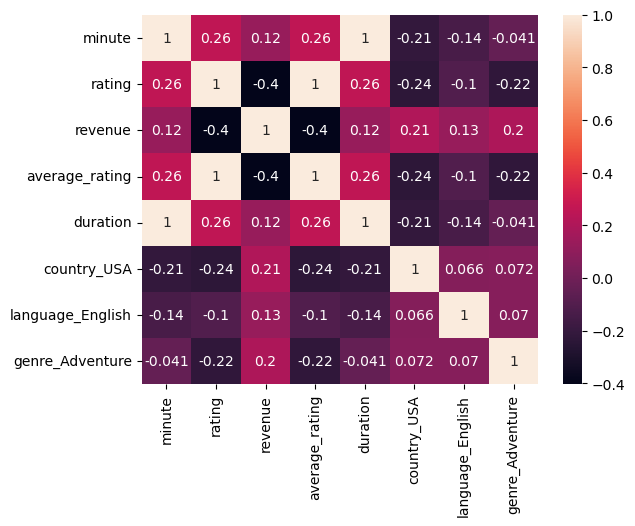

In [58]:
import seaborn as sns
numerical_cols = ['minute', 'rating', 'revenue', 'average_rating', 'duration', 'country_USA', 'language_English',
'genre_Adventure']
correlation_matrix = merged_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot = True)

In [59]:
# feature_red_data = merged_data.drop(columns = ["id", "date", "description", "role", "type", "average_rating", "minute"])
# feature_red_data

## Model Training and Evaluation

In [60]:
# Train and evaluate the model act
# train_and_evaluate_model(merged_data)

### Data Cleanup

In [61]:
X = merged_data.drop(columns=['revenue', 'description'])  # Drop unnecessary columns
y = merged_data['revenue']

print("Columns: ", X.columns)

# Convert data to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

Columns:  Index(['id', 'date', 'minute', 'rating', 'top_actors_count', 'role', 'type',
       'average_rating', 'duration', 'genre_Adventure', 'genre_Animation',
       'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'genre_War', 'genre_Western', 'language_Cantonese',
       'language_Chinese', 'language_Czech', 'language_Dutch',
       'language_English', 'language_Finnish', 'language_French',
       'language_German', 'language_Greek (modern)',
       'language_Hebrew (modern)', 'language_Hindi', 'language_Hungarian',
       'language_Italian', 'language_Japanese', 'language_Khmer',
       'language_Korean', 'language_Latin', 'language_Norwegian',
       'language_Persian (Farsi)', 'language_Polish', 'language_Romanian',
       'language_Russian', 'language_Somali', 'language_Spanish',
       'language_Swahili

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with the best hyperparameters
model = RandomForestRegressor(random_state=42)



### Hyper Parameter Search

In [63]:

# Define the hyperparameter grid
#     param_grid = {
#         "n_estimators": [50, 100, 200, 300],  # Number of trees
#         "max_depth": [None, 10, 20, 30], # Depth of trees
#         "min_samples_split": [2, 5, 10, 20], # Minimum samples required to split a node
#         "min_samples_leaf": [1, 2, 5, 10], # Minimum samples required to form a leaf
#         "max_features": ["sqrt", "log2", None] # Number of features to consider at each split
#     }
    
    
param_grid = {
        "n_estimators": [100, 200],  # Number of trees
        "max_depth": [10, 20], # Depth of trees
        "min_samples_split": [5, 10], # Minimum samples required to split a node
        "min_samples_leaf": [2, 5], # Minimum samples required to form a leaf
        "max_features": ['sqrt']  # Number of features to consider at each split
    }

# Set up the grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use MSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best hyperparameters found from previous RandomizedSearchCV
best_params = grid_search.best_params_
model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### Learning Curve

In [64]:
# Use learning_curve to get training and testing scores for different sizes of training data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

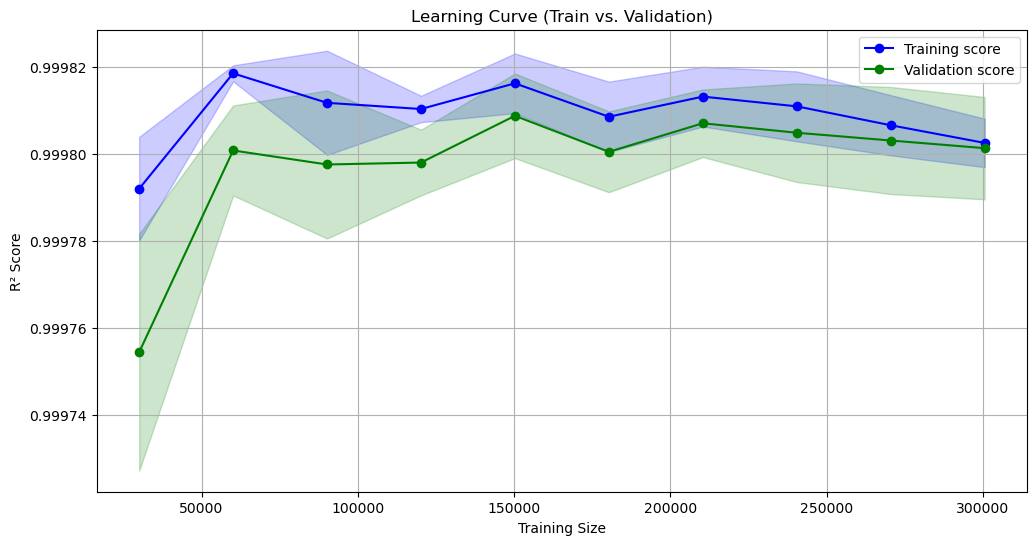

In [65]:
# Plotting the learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Validation score', color='green', marker='o')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve (Train vs. Validation)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.show()

### Model Training

In [66]:
# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the training and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Print MAE and MSE for both training and test sets
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Save the best model
joblib.dump(model, 'Random_Forest_Regressor_model_best.pkl')
print("Best model saved to 'Random_Forest_Regressor_model_best.pkl'")

Training MAE: 570918.5995317323
Test MAE: 561517.9002185547
Training MSE: 7366689260441.848
Test MSE: 6796702750563.998
Best model saved to 'Random_Forest_Regressor_model_best.pkl'


### Prediction vs Actual 

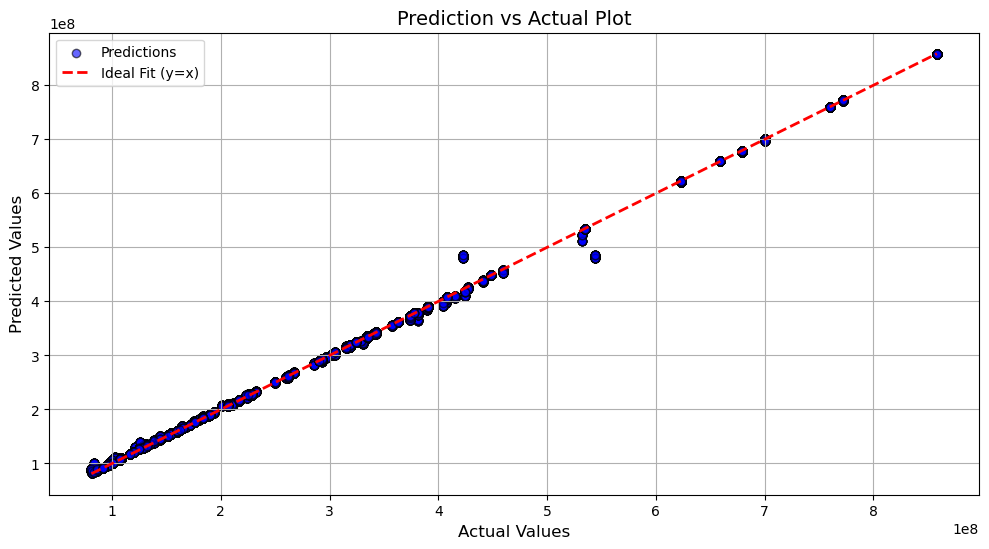

In [67]:
y_pred = test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor="k", label="Predictions")

# Plot the diagonal line (y = x)
line_min = min(np.min(y_test), np.min(y_pred))
line_max = max(np.max(y_test), np.max(y_pred))
plt.plot([line_min, line_max], [line_min, line_max], color='red', linestyle='--', linewidth=2, label="Ideal Fit (y=x)")

# Add labels, title, and legend
plt.title("Prediction vs Actual Plot", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()